# Loads the processed h5 file and plots data

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys
from scipy import signal as ssig

In [2]:
sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *

In [3]:
run = '0018_droplets_10um_2mm'#'0011_jet10um_RT'#
h5path = '/sf/bernina/data/p17743/res/work/hdf5/run%s.h5'%run
h5file = h5py.File(h5path,'r')

In [22]:
img = h5file['JF7/2D_sum'][:]
r  = h5file['JF7/Q_bins'][:]
Iq = h5file['JF7/I_Q'][:]
i0 = h5file['JF7/i0'].value 
nshots = h5file['JF7/num_shots'].value
q = q_scale(r, detector_distance=0.12)
print(nshots)

18000


<IPython.core.display.Javascript object>


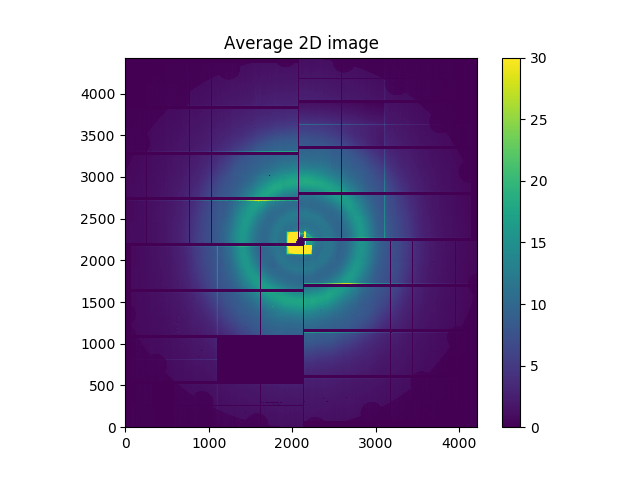

In [23]:
plt.figure()
plt.title('Average 2D image')
plt.imshow(img/nshots,clim=[0,30],origin='lower')
plt.colorbar()
plt.show()

In [24]:
#normalise
Iq_norm = np.zeros(Iq.shape)
for i in range(1,nshots):
    Iq_norm[i]=Iq[i]#/i0[i]
print(i0)



[  0.           0.4002153    0.63014692 ...,  59.5462265   17.62623405
  76.64690399]


<IPython.core.display.Javascript object>


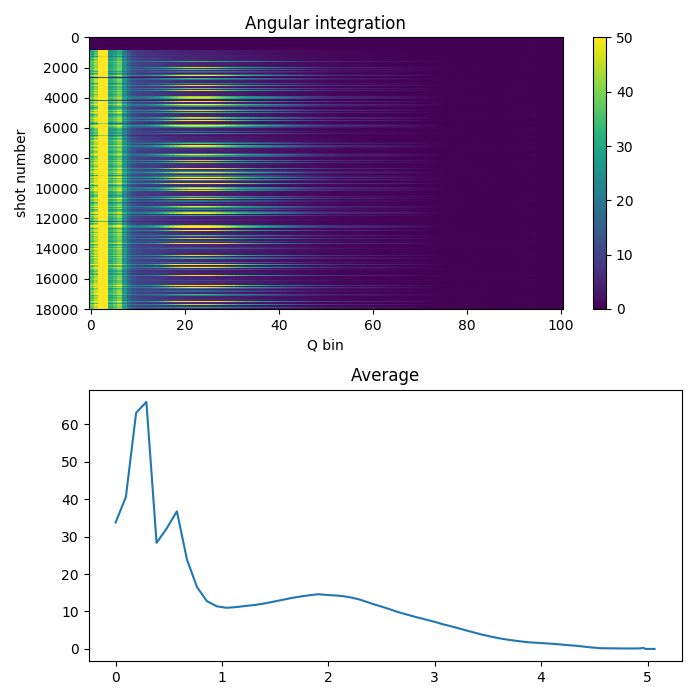

In [26]:
plt.figure(figsize=[7,7])

plt.subplot(2,1,1)
plt.imshow(Iq_norm,aspect='auto',clim=[0,50])
plt.title('Angular integration')
plt.xlabel('Q bin')
plt.ylabel('shot number')
plt.colorbar()

plt.subplot(2,1,2)
plt.title('Average')
plt.plot(q, np.average(Iq_norm,axis=0))
plt.tight_layout()
plt.show()

In [27]:
#define hits
iq_threshold = 5
iq_metric = Iq_norm[:,10:80].mean(axis=1)
hits = (iq_metric>iq_threshold)

hit rate: 31.900000


<IPython.core.display.Javascript object>


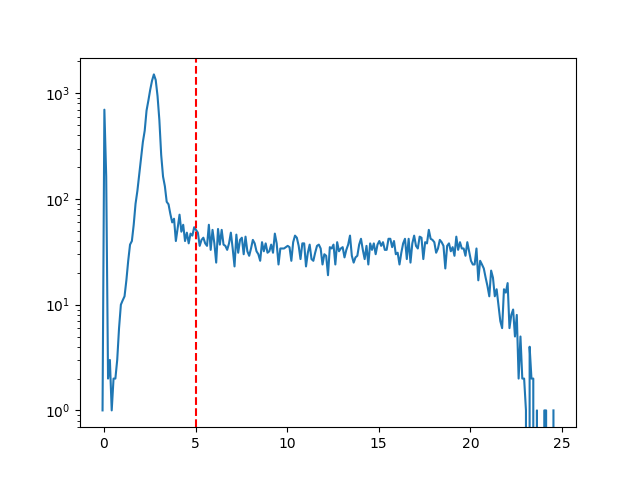

In [28]:
print('hit rate: %f'%(len(hits[hits>0])/nshots*100))

bi,bf,db = iq_metric.min(),iq_metric.max(),.1
bins = np.arange(bi-db,bf+db,db)
hy,hx = np.histogram(iq_metric,bins=bins)
bin_centers = np.array([(bins[j]+bins[j+1])/2. for j in range(len(bins)-1)])

plt.figure()
plt.plot(bin_centers, hy, label='data')
plt.yscale('log',nonposy='clip')
plt.axvline(x=iq_threshold,ls='--',c='r')
#plt.xlim(-.1,.2)
plt.show()

<IPython.core.display.Javascript object>


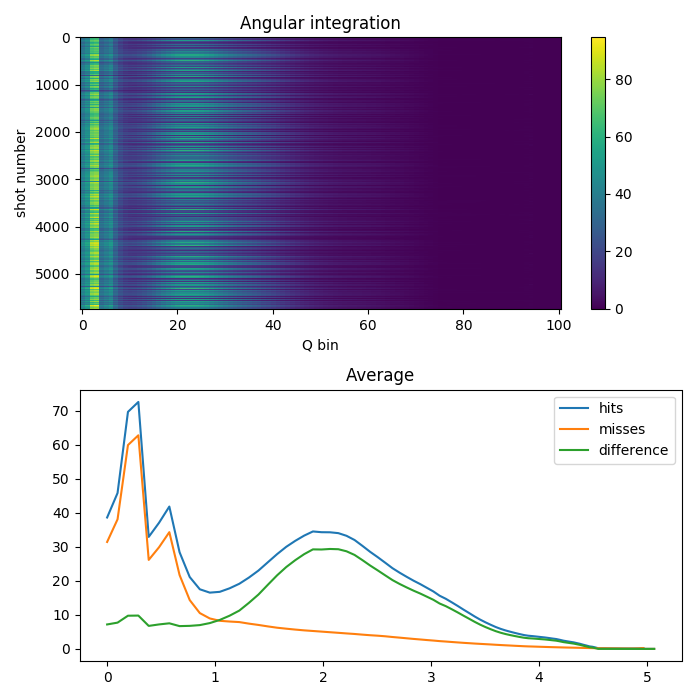

In [29]:
plt.figure(figsize=[7,7])

Iq_hits = Iq_norm[hits,:]
Iq_miss = Iq_norm[np.logical_not(hits),:]


plt.subplot(2,1,1)
plt.imshow(Iq_hits,aspect='auto')
plt.title('Angular integration')
plt.xlabel('Q bin')
plt.ylabel('shot number')
plt.colorbar()

hit_avg  = np.average(Iq_hits,axis=0)
miss_avg = np.average(Iq_miss,axis=0)

plt.subplot(2,1,2)
plt.title('Average')
plt.plot(q, hit_avg)
plt.plot(q, miss_avg)
plt.plot(q, hit_avg - miss_avg)
plt.legend(['hits', 'misses', 'difference'])
plt.tight_layout()
plt.show()

In [30]:
from escape.parse import swissfel
data = swissfel.parseScanEco_v01('/sf/bernina/data/p17743/res/scan_info/run%s.json'%run,
                                 createEscArrays=True, 
                                 memlimit_mD_MB=50)
jfcode = data['JF07T32V01']
jf_pulse_id = jfcode.eventIds[:nshots]
print(jf_pulse_id)

evcode = data['SAR-CVME-TIFALL5:EvtSet']
ons = evcode.data[:,20].compute()
pulse_id = evcode.eventIds#.compute()
print(pulse_id)

thegood_ideas = np.isin(pulse_id, jf_pulse_id)
print(np.sum(thegood_ideas))
print(len(jf_pulse_id))

ons = ons[thegood_ideas].astype(np.bool) # KEYYYYYYYYYYYYYYYYYYYYYYYY
print(ons)

Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 3
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 3
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 3
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 3
Found em

<IPython.core.display.Javascript object>


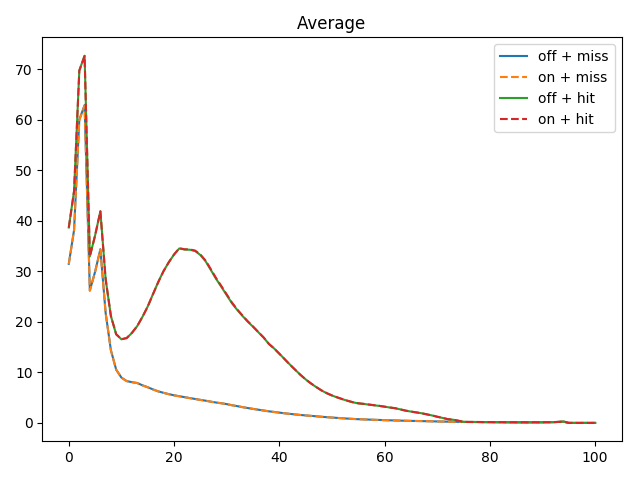

In [31]:
nicht = np.logical_not

off_miss = np.average(Iq_norm[nicht(hits) * nicht(ons),:], axis=0)
on_miss  = np.average(Iq_norm[nicht(hits) * ons,:], axis=0)

off_hit  = np.average(Iq_norm[hits * nicht(ons),:], axis=0)
on_hit   = np.average(Iq_norm[hits * ons,:], axis=0)

plt.figure()
plt.subplot(1,1,1)
plt.title('Average')
plt.plot(off_miss)
plt.plot(on_miss,'--')
plt.plot(off_hit,'-')
plt.plot(on_hit,'--')
plt.legend(['off + miss', 'on + miss', 'off + hit', 'on + hit'])
plt.tight_layout()
plt.show()

In [35]:
# get a number| of off hits equal to the number of on hits for SNR estimation
off_hits = Iq_norm[hits * nicht(ons),:]
off_hits_1 = np.average(off_hits[:-1:2], axis=0)
off_hits_2 = np.average(off_hits[1::2], axis=0)
off_diff = normalize(off_hits_1, l, h) - normalize(off_hits_2, l, h)

<IPython.core.display.Javascript object>


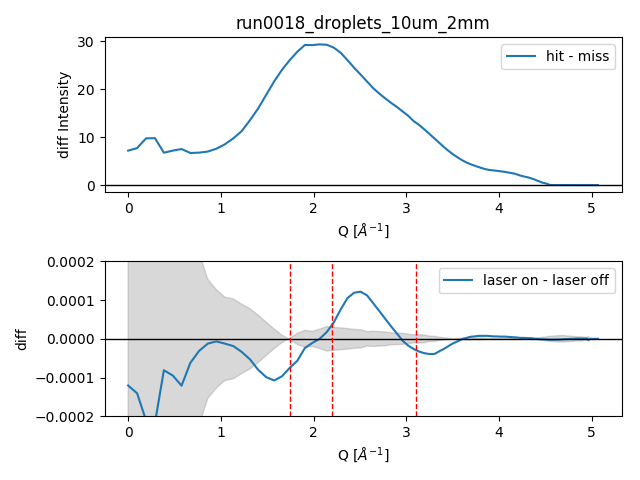

In [44]:
def normalize(array, lower_index, upper_index):
    n = np.sum(array[lower_index:upper_index])
    norm_array = array / n
    return norm_array

l = 12
h = 70
signal = (normalize(on_hit, l, h) - normalize(off_hit, l, h))# /  normalize(off_hit, l, h)

plt.figure()

plt.subplot(2,1,1)
plt.title('run%s'%run)
plt.plot(q, hit_avg - miss_avg)
plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('diff Intensity')
plt.legend(['hit - miss'])
plt.axhline(0,c='black',lw=1)

ax = plt.subplot(2,1,2)
ax.plot(q, signal)
#ax.plot(off_diff, lw=0.5, c='k')
ax.fill_between(q, -off_diff, off_diff, color='grey', alpha=0.3)
plt.xlabel('q')
plt.ylabel('diff')
plt.ylim([-2e-4,2e-4])
plt.xlabel('Q [$\AA^{-1}$]')
plt.axhline(0,c='black',lw=1)
plt.axvline(1.75,c='red',lw=1,ls='--')
plt.axvline(2.2,c='red',lw=1,ls='--')
plt.axvline(3.1,c='red',lw=1,ls='--')
plt.legend(['laser on - laser off'])
plt.tight_layout()


plt.savefig('run%s_radial_profile_even_vs_odd_normalized+zoom.png' % run)
plt.show()